In [1]:
import numpy as np
import matplotlib.pyplot as plt
import foscat.scat_cov as sc
import foscat.Synthesis as synthe
f=sc.funct()

In [2]:
path='/home/jmdeloui/CO2TEST/'


In [3]:
#***check if data is uploaded depending on choices
atm = 1

x=[]

CO2_coeff_tab = [0.8,0.9,1.00, 1.10, 1.20]
for k in range(5):
    CO2_coeff = CO2_coeff_tab[k]
    for b in range(3):
        band=b+1
        
        #Choose line to read
        
        Ps_ind = 6 #(/ 893, 923, 953, 983, 1013, 1043 /) in hPa
        sza_ind = 15 #(/ 0.014, 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70. /)
        H2O_ind = 9 #(/ 0.60, 0.70, 0.80, 0.90, 1.00, 1.10, 1.20, 1.30, 1.40 /) 
        alb_ind = 4 #(/ 0.05, 0.25, 0.45, 0.65 /)
        ########################################################################################
        
        file_learning = path+f'basis_{CO2_coeff:.2f}CO2_microcarb_B{band}_atm000{atm}.ddb'
        
        if band==1:
            n = 365
        elif band==2:
            n = 335
        elif band==3:
            n = 348
        
        target_line = 540*(Ps_ind - 1) + 36*(sza_ind - 1) + 4*(H2O_ind - 1) + alb_ind + 1 #+1 because the first line are wavenumbers
        #3241 lines? So 3240 without the wavenumbers
        
        with open(file_learning, 'rb') as file:
            #for i in range(target_line-1):
        #        junk = np.fromfile(file,dtype='float32', count=1000)
        #        print(junk)
        #    line_read = np.fromfile(file,dtype='float32',count=1000)
        
        
            line_read = np.fromfile(file,dtype='float32',count=-1)
            index = np.where(line_read !=0)
            index = index[0]
        
        #line_read contains the whole document, we remove all the null values
        line_learning = []
        for i in range(len(line_read)):
            if line_read[i] != 0:
                line_learning.append(line_read[i])
        
        
        #we store the first line containing the wavenumbers
        wavenumber = line_learning[0:n]
        
        #we separate the long list into lines (4 parameters, then spectra of length n, 3240 times)
        line_size = n+4 #for the 4 parameters at the start of each line before the spectra
        rad_learning = np.zeros((3240,line_size))
        
        for i in range(3240):
            ind = i*line_size + len(wavenumber)
            rad_learning[i,:] = line_learning[ind:ind+line_size]
        if b==0:
            rad_learning_band=rad_learning[:,4:]
        else:
            rad_learning_band=np.concatenate([rad_learning_band,rad_learning[:,4:]],1)
            
    x.append(rad_learning_band)

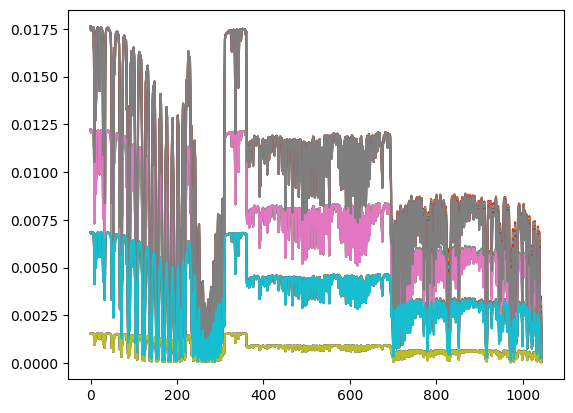

In [4]:
for k in range(30):
    plt.plot(x[0][k,4:])

In [5]:
data=np.vstack(x)
co2=(5*np.arange(data.shape[0])/data.shape[0]).astype('int')
idx=np.argsort(np.random.rand(data.shape[0]))
amp=np.median(data,1)
data/=amp[:,None]
data=data[idx]
co2=co2[idx]

data_train=data[0:data.shape[0]*2//3]
co2_train=co2[0:data.shape[0]*2//3]
data_valid=data[data.shape[0]*2//3:]
co2_valid=co2[data.shape[0]*2//3:]

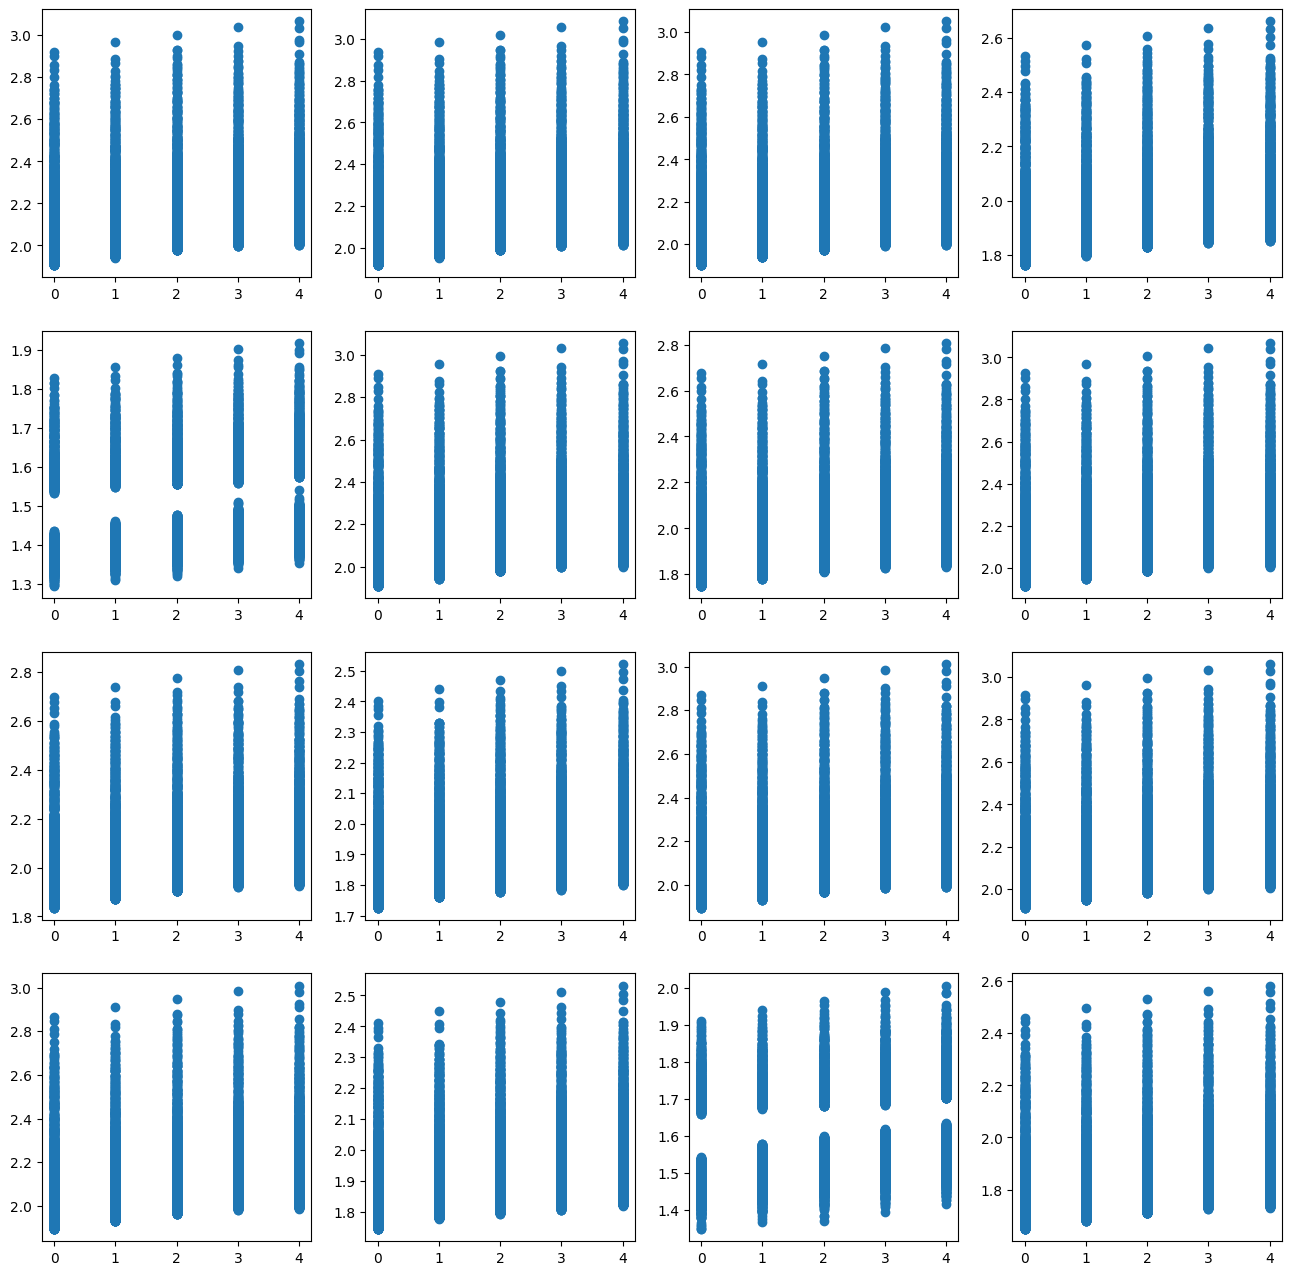

In [6]:
plt.figure(figsize=(16,16))
for k in range(16):
    plt.subplot(4,4,1+k)
    plt.scatter(co2_train,data_train[:,k*4])

In [7]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(data_train)

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


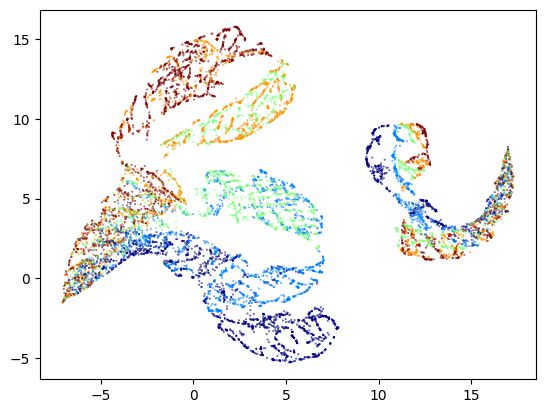

In [8]:
plt.scatter(X_umap[:,0],X_umap[:,1],c=co2_train,cmap='jet',s=0.1)

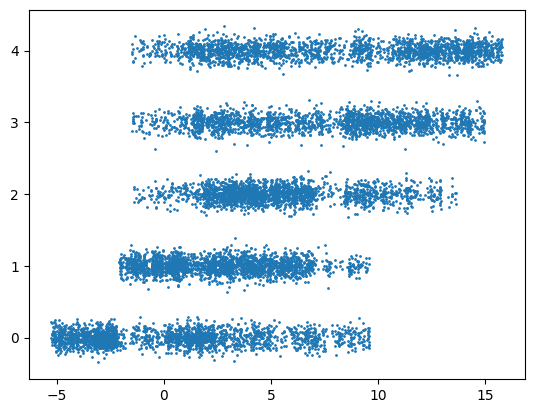

In [9]:
plt.scatter(X_umap[:,1],co2_train+np.random.randn(co2_train.shape[0])/10,s=1)

In [10]:
N_val=data_train.shape[1]
N_class=5
N_level=1

import torch

def select_from_tensor(A, I):
    """
    A: torch.Tensor of shape (N, M)
    I: torch.LongTensor of shape (N,) with indices per row
    Returns: torch.Tensor of shape (N,) where result[i] = A[i, I[i]]
    """
    N = A.shape[0]
    batch_indices = torch.arange(N, device=A.device)
    result = A[batch_indices, I]
    return result
    
def compute_nn():

    nn=N_val*N_class+N_class
    for k in range(1,N_level):
        nn+=N_class*N_class+N_class
    return nn
    
def compute(x,scat_operator,x_train):

    nn=0
    w=scat_operator.backend.bk_reshape(x[0:N_val*N_class],[N_val,N_class])
    b=scat_operator.backend.bk_reshape(x[N_val*N_class:N_val*N_class+N_class],[1,N_class])
    logits=scat_operator.backend.bk_matmul(x_train, w) + b
    nn+=N_val*N_class+N_class
    for k in range(1,N_level):
        logits = scat_operator.backend.bk_relu(logits)
        w=scat_operator.backend.bk_reshape(x[nn:nn+N_class*N_class],[N_class,N_class])
        b=scat_operator.backend.bk_reshape(x[nn+N_class*N_class:nn+N_class*N_class+N_class],[1,N_class])
        logits=scat_operator.backend.bk_matmul(logits, w) + b
        nn+=N_class*N_class+N_class
    
    return scat_operator.backend.backend.nn.functional.softmax(logits, dim=-1) 
    
def The_loss(x,scat_operator,args,return_all=False):

    x_train  = args[0]
    itrain   = args[1]
    
    learn=compute(x,scat_operator,x_train)
    loss = -scat_operator.backend.bk_log(select_from_tensor(learn,itrain))
    return scat_operator.backend.bk_reduce_mean(loss)

In [102]:
%%time
w=(np.random.rand(compute_nn())-0.5)/np.sqrt(N_class)*0.1

loss=synthe.Loss(The_loss,f,
                f.backend.bk_cast(data_train),
                co2_train)

sy = synthe.Synthesis([loss])

w=sy.run(f.backend.bk_cast(w),EVAL_FREQUENCY=100,NUM_EPOCHS = 20)

Total number of loss  1
Itt      0 L=      1.89 (      1.89 ) 0.019s 
Final Loss  1.4360978603363037
CPU times: user 1.2 s, sys: 8.46 ms, total: 1.21 s
Wall time: 394 ms


[0.39835292 0.23879492 0.17433068 0.09546214 0.09305926]


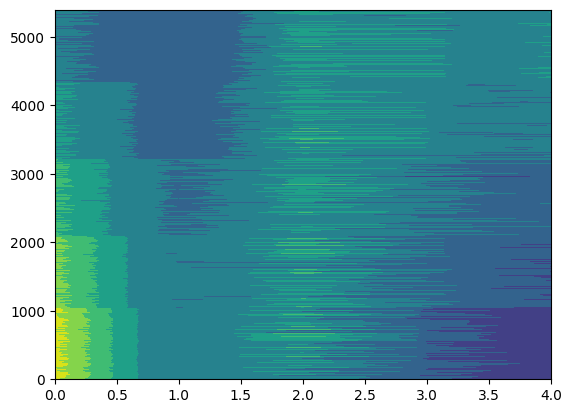

In [103]:
res=compute(f.backend.bk_cast(w),f,f.backend.bk_cast(data_valid)).cpu().numpy()

idx=np.argsort(co2_valid)
plt.contourf(res[idx])
print(res[0])

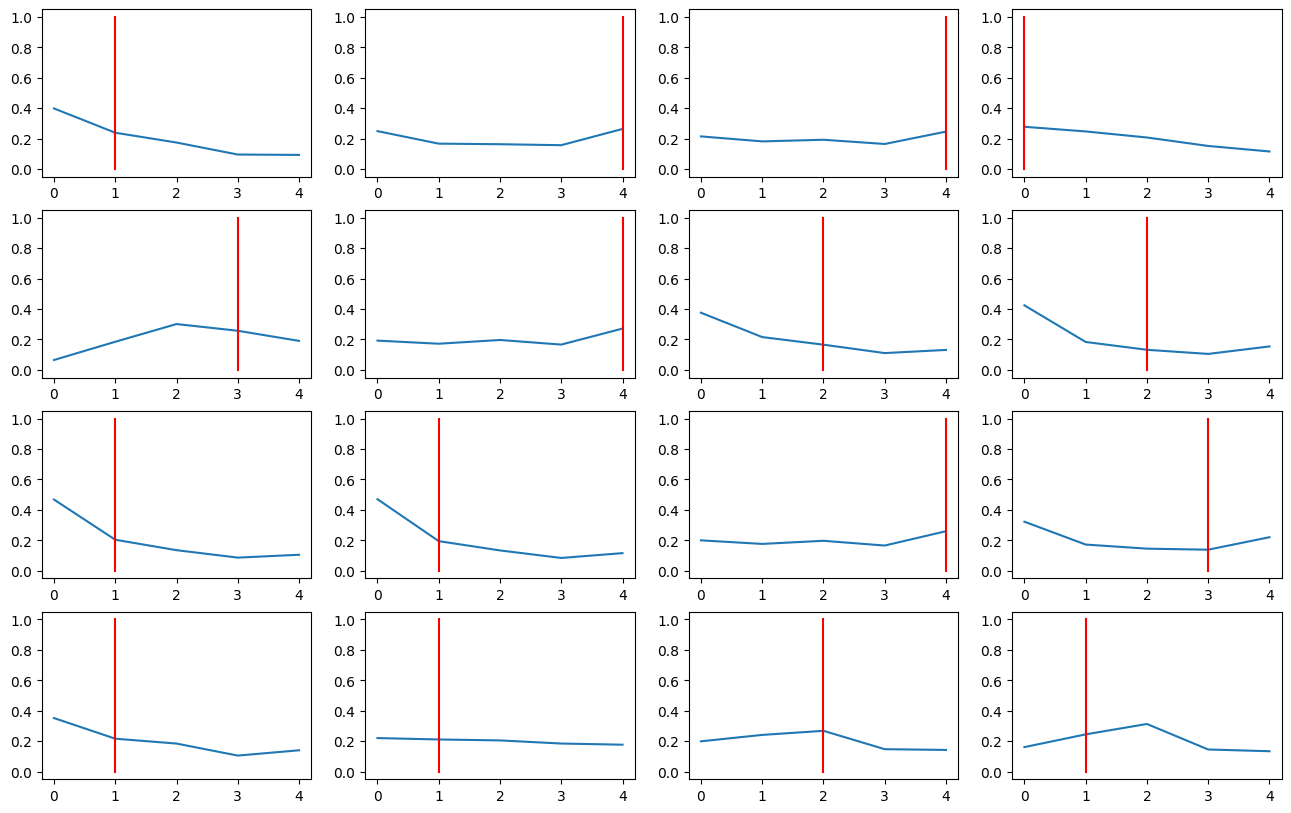

In [104]:
plt.figure(figsize=(16,10))
for k in range(16):
    plt.subplot(4,4,1+k)
    plt.plot(res[k])
    plt.plot([co2_valid[k],co2_valid[k]],[0,1],color='r')

(array([  13.,   13.,    8.,   21.,   26.,   36.,   78.,   70.,   67.,
          53.,   67.,   85.,  161.,  125.,  150.,  226.,  309.,  335.,
         165.,  314.,  308.,  408.,  451.,  440.,  391.,   13.,    0.,
           0.,    0., 1067.]),
 array([0.02744868, 0.05986706, 0.09228544, 0.12470382, 0.15712219,
        0.18954059, 0.22195897, 0.25437734, 0.28679574, 0.31921411,
        0.35163251, 0.38405088, 0.41646925, 0.44888765, 0.48130602,
        0.51372439, 0.54614276, 0.57856113, 0.6109795 , 0.64339793,
        0.6758163 , 0.70823467, 0.74065304, 0.77307141, 0.80548978,
        0.83790821, 0.87032658, 0.90274495, 0.93516332, 0.96758169,
        1.00000012]),
 [<matplotlib.patches.Polygon at 0x7f129caae790>])

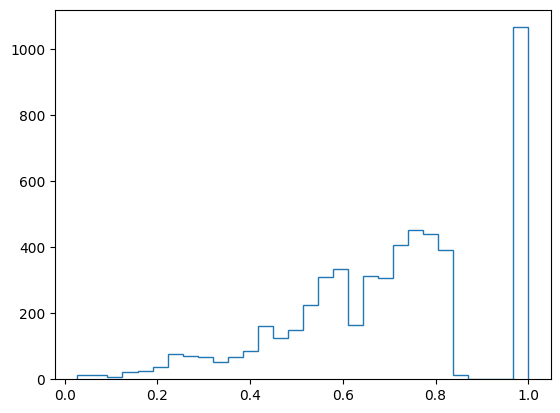

In [105]:
resc=np.cumsum(res,1)
plt.hist(resc[np.arange(co2_valid.shape[0]),co2_valid],histtype='step',bins=30)

In [106]:
import csv

########################################################################################
scene = 'reims'
########################################################################################


file_scene_param = path+f'/plume_{scene}_ALLparameters'
file_scene_B1 = path+f'/plume_{scene}_B1'
file_scene_B2 = path+f'/plume_{scene}_B2'
file_scene_B3 = path+f'/plume_{scene}_B3'

if scene=='reims':
    n_pixel = 665
    x = 20/3
elif scene=='berlin':
    n_pixel = 289
    x = 30/8


scene_param = np.zeros((n_pixel, 6)) #lat, lon, XCO2, sza, Ps, H2O
scene_B1 = np.zeros((n_pixel, 365))
scene_B2 = np.zeros((n_pixel, 335))
scene_B3 = np.zeros((n_pixel, 348))


#Read parameters file
with open(file_scene_param) as file:
    j = 0
    line = 0
    reader = csv.reader(file, delimiter=' ')
    for row in reader:

        #Remove empty spaces in list
        row = list(filter(None, row))
        row = ' '.join(row).split()
        
        #print(row)

        if (j%2==0):
            scene_param[line,0] = row[0] #lat
            scene_param[line,1] = row[1] #lon
            scene_param[line,2] = row[2] #XCO2
            scene_param[line,3] = row[3] #sza
            scene_param[line,4] = row[4] #Ps
            #line = line+1
        else:
            scene_param[line,5] = row[0]
            line = line+1

        j = j+1



# Read file for all 3 bands

with open(file_scene_B1) as file:
    j = 0
    line = 0
    reader = csv.reader(file, delimiter=' ')
    for row in reader:

        #Remove empty spaces in list
        row = list(filter(None, row))
        row = ' '.join(row).split()
        
        #print(row)

        scene_B1[j,:] = row[:]

        j = j+1

with open(file_scene_B2) as file:
    j = 0
    line = 0
    reader = csv.reader(file, delimiter=' ')
    for row in reader:

        #Remove empty spaces in list
        row = list(filter(None, row))
        row = ' '.join(row).split()
        
        #print(row)

        scene_B2[j,:] = row[:]

        j = j+1

with open(file_scene_B3) as file:
    j = 0
    line = 0
    reader = csv.reader(file, delimiter=' ')
    for row in reader:

        #Remove empty spaces in list
        row = list(filter(None, row))
        row = ' '.join(row).split()
        
        #print(row)

        scene_B3[j,:] = row[:]

        j = j+1


lat=scene_param[:,0]
lon=scene_param[:,1]

In [107]:
new_data=np.concatenate([scene_B1,scene_B2,scene_B3],1)
print(new_data.shape,data.shape)
amp=np.median(new_data,1)
new_data/=amp[:,None]
res=compute(f.backend.bk_cast(w),f,f.backend.bk_cast(new_data)).cpu().numpy()
res.shape

(665, 1048) (16200, 1048)


(665, 5)

In [222]:
from scipy.interpolate import griddata

# Convert lon/lat to HEALPix spherical angles
theta = np.deg2rad(90.0 - lat).flatten()
phi   = np.deg2rad(lon).flatten()

level=11

nside = 2**level

# Compute interpolation indices and weights (HEALPix -> UTM pixels)
cell_ids = hp.ang2pix(nside, theta, phi, nest=True)
t,p = hp.pix2ang(nside,cell_ids,nest=True)
print(t.shape,theta.shape,res.shape)
vals=np.zeros([5,cell_ids.shape[0]])
for k in range(5):
    vals[k]=griddata(np.c_[p, t], res[:,k], (phi, theta), method='nearest')

(665,) (665,) (665, 5)


In [223]:
idx=np.where(np.isfinite(vals[0]))[0]
cell_ids=cell_ids[idx]
vals=vals[:,idx]

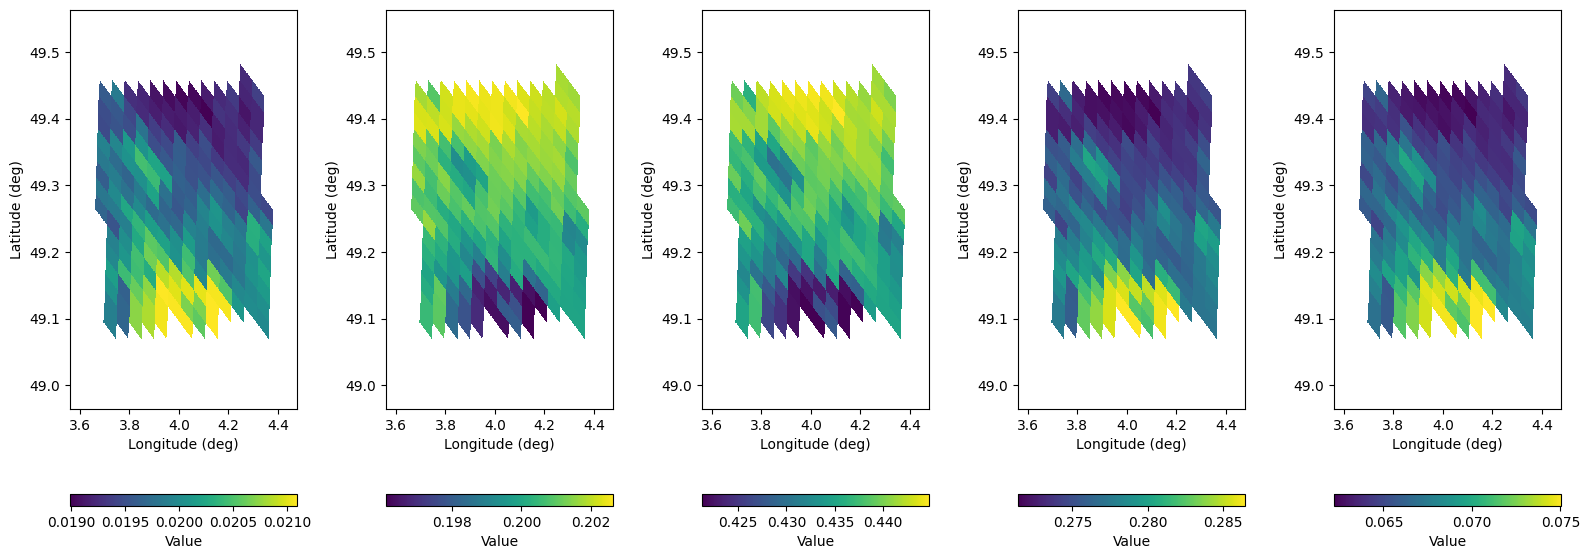

In [224]:
from foscat.Plot import lgnomproject

plt.figure(figsize=(16,6))
for k in range(5):
    lgnomproject(cell_ids,vals[k],2**level,hold=False,sub=(1,5,1+k),cbar=True,fov_deg=0.6)

In [225]:
new_data.shape,cell_ids.shape

((665, 1048), (665,))

In [226]:
import foscat.scat_cov as sc

f=sc.funct()

ref_scat=f.reduce_mean_batch(f.eval(new_data.T,cell_ids=cell_ids,nside=2**level,norm='self'))

In [227]:
co2_conc=f.backend.bk_cast(np.array([0.8,0.9,1.0,1.1,1.2]).reshape(1,5))

def The_loss_scat(x,scat_operator,args,return_all=False):

    #ref_scat  = args[0]
    
    learn=scat_operator.eval(x,cell_ids=cell_ids,nside=2**level)
    
    return scat_operator.reduce_distance(learn,ref_scat)


def The_loss_co2(x,scat_operator,args,return_all=False):

    ref_co2   = args[0]

    learn_co2=(x[:,None]-co2_conc)*(x[:,None]-co2_conc)*ref_co2
    
    return scat_operator.backend.bk_reduce_mean(learn_co2)

In [228]:
imap=f.backend.bk_cast(np.random.randn(vals.shape[1]))
print(The_loss_co2(imap,f,(f.backend.bk_cast(vals.T),)))
print(The_loss_scat(imap,f,(ref_scat,)))

tensor(0.3876, device='cuda:0')
tensor(0.0023, device='cuda:0')


In [229]:
loss1=synthe.Loss(The_loss_scat,f,ref_scat)

loss2=synthe.Loss(The_loss_co2,f,f.backend.bk_cast(vals.T))

sy = synthe.Synthesis([loss1,loss2])

w=sy.run(imap,EVAL_FREQUENCY=1,NUM_EPOCHS = 20)

Total number of loss  2
Itt      0 L=     0.195 (   0.00234      0.388 ) 0.035s 
Itt      1 L=     0.145 (   0.00179      0.287 ) 0.091s 
Itt      2 L=  0.000815 (  3.98e-05    0.00159 ) 0.030s 
Itt      3 L=  0.000815 (  3.98e-05    0.00159 ) 0.031s 
Itt      4 L=  0.000815 (  3.98e-05    0.00159 ) 0.037s 
Itt      5 L=  0.000815 (  3.98e-05    0.00159 ) 0.288s 
Final Loss  0.0008151197107508779


<Axes: xlabel='Longitude (deg)', ylabel='Latitude (deg)'>

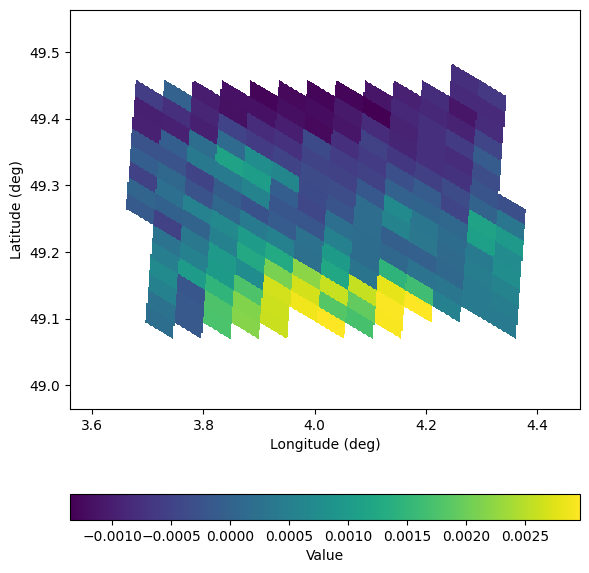

In [233]:
plt.figure(figsize=(6,6))

lgnomproject(cell_ids,w-np.median(w),2**level,hold=False,fov_deg=0.6,cbar=True)